 Code for the introductory example in our paper

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cuqi
assert cuqi.__version__ == '0.3.0'

In [2]:
from cuqi.testproblem import Deconvolution2D
from cuqi.distribution import Gaussian, Laplace_diff, Gamma
from cuqi.problem import BayesianProblem
from cuqi.data import imresize, rgb2gray

In [3]:
# Load cookie.png from current folder.
cookie = plt.imread('cookie2.png')

# Convert to rgb.
cookie = cookie[:, :, :3]

# Convert to grayscale.
cookie = rgb2gray(cookie)

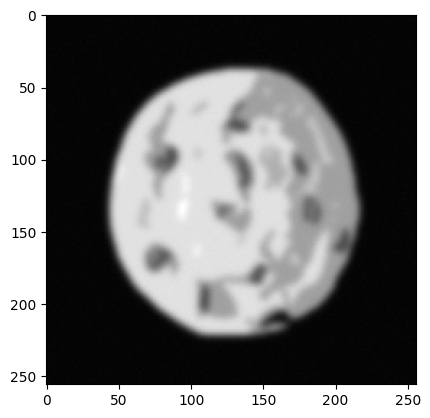

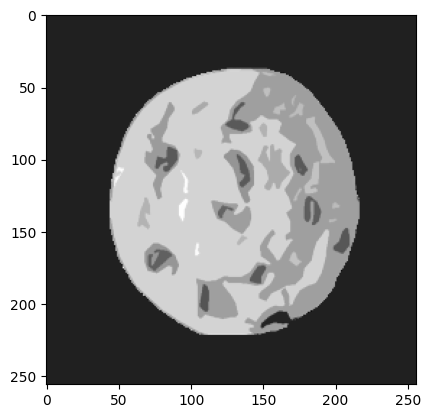

In [4]:
A, y_data, info = Deconvolution2D.get_components(dim=256, phantom=cookie)
y_data.plot(); plt.show()
info.exactSolution.plot(); plt.show()

Computing 1000 samples
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is experimental. !!!
!!!    Always validate the computed results.     !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using Gibbs sampler
burn-in: 20%

Automatically determined sampling strategy:
	x: UnadjustedLaplaceApproximation
	d: ConjugateApprox
	s: Conjugate

Warmup 200 / 200
Sample 1000 / 1000
Elapsed time: 830.1739919185638
Plotting results


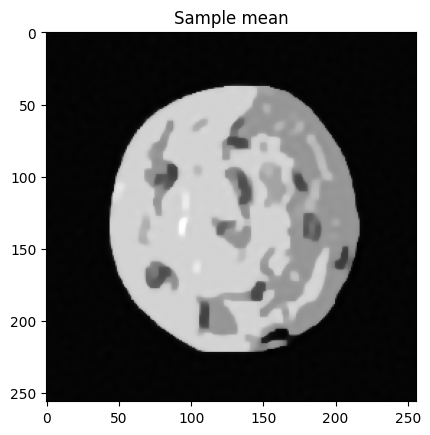

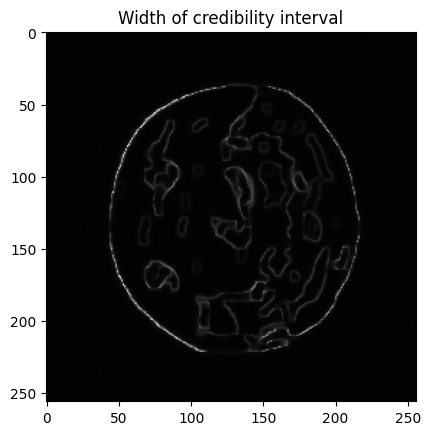

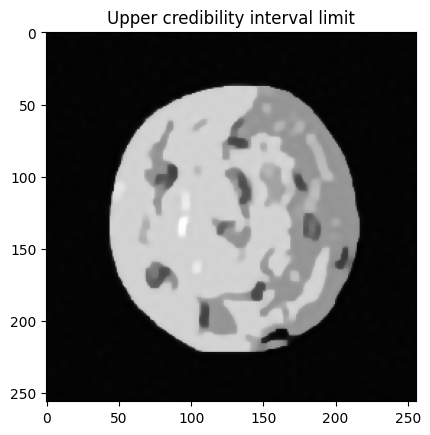

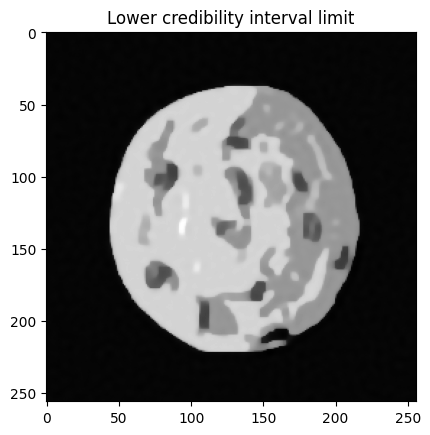

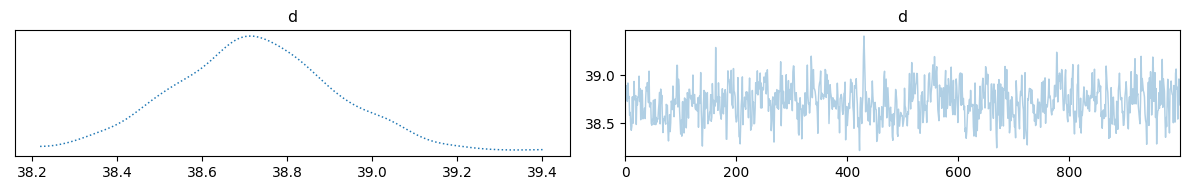

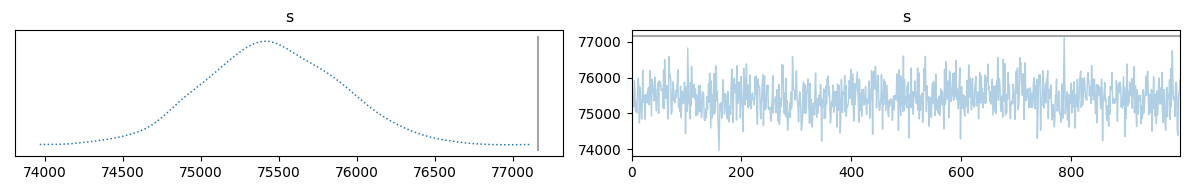

In [5]:
hyperparameters = True
if not hyperparameters:
    x = Laplace_diff(np.zeros(A.domain_dim), 0.1, physical_dim=2)
    y = Gaussian(A @ x, 0.0036**2)
    BP = BayesianProblem(x, y)
    BP.set_data(y=y_data)
    samples = BP.UQ(200)
    samples = {"x": samples} # For compatibility with the next cell.
else:
    d = Gamma(1, 1e-4)
    s = Gamma(1, 1e-4)
    x = Laplace_diff(np.zeros(A.domain_dim), lambda d: 1/d, physical_dim=2)
    y = Gaussian(A @ x, lambda s: 1/s)
    BP = BayesianProblem(x, y, d, s)
    BP.set_data(y=y_data)
    samples = BP.UQ(1000,exact={"s": 1/(0.0036**2)})

Text(0.5, 1.0, 'Posterior Standard Deviation')

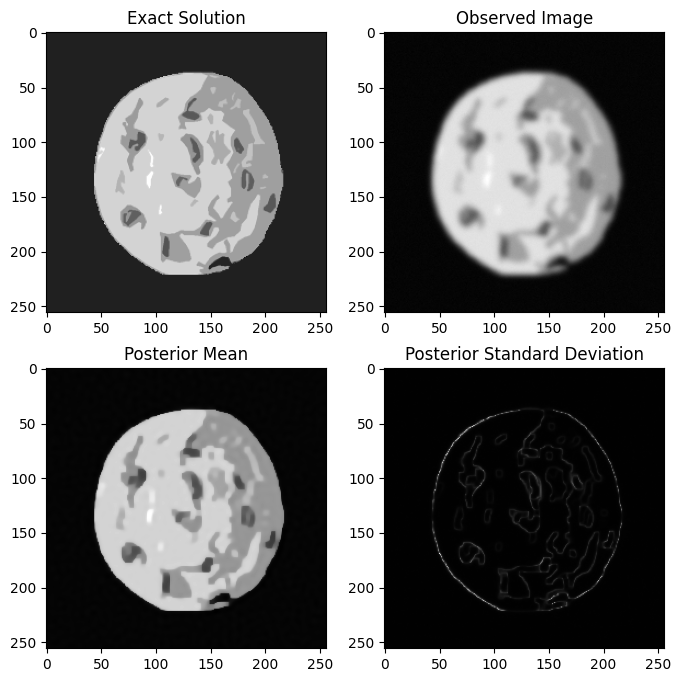

In [6]:
# Extract sample mean and variance
mean = samples["x"].mean()
var = np.sqrt(samples["x"].variance())


# Subplot mean, with data and exact solution
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

ax[0][0].imshow(info.exactSolution.reshape(256, 256), cmap='gray')
ax[0][0].set_title('Exact Solution')

ax[0][1].imshow(y_data.reshape(256, 256), cmap='gray')
ax[0][1].set_title('Observed Image')

ax[1][0].imshow(mean.reshape(256, 256), cmap='gray')
ax[1][0].set_title('Posterior Mean')

ax[1][1].imshow(var.reshape(256, 256), cmap='gray')
ax[1][1].set_title('Posterior Standard Deviation')



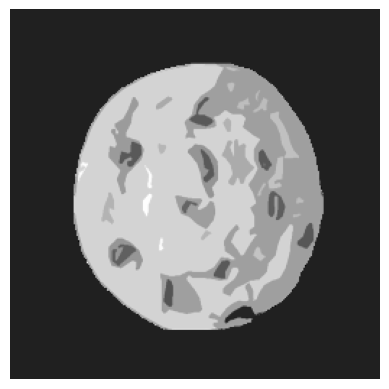

In [7]:
info.exactSolution.plot(); plt.axis('off'); plt.show(); 

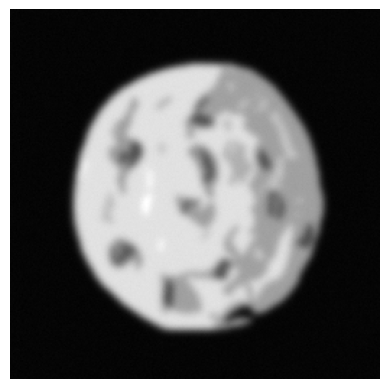

In [8]:
y_data.plot(); plt.axis('off'); plt.show(); 

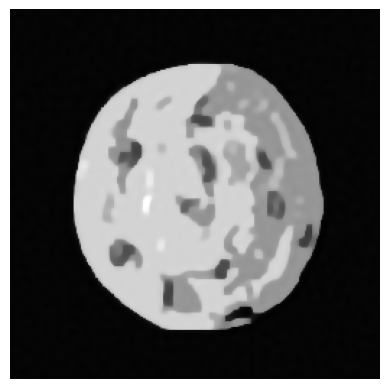

In [9]:
samples["x"].plot_mean(); plt.title(''); plt.axis('off'); plt.show()

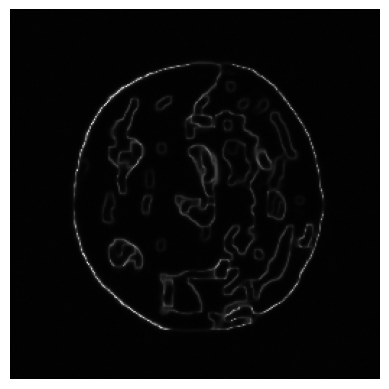

In [10]:
samples["x"].plot_ci_width(); plt.title(''); plt.axis('off'); plt.show()

In [11]:
# Print nicely statistics of s and d. Only works if hyperparameters=True.
# Print the mean and 99% credible interval in a nice table.
# Use f" " type string format. 

if hyperparameters:
    print(f"{'':<10} {'mean':<10} {'lower':<10} {'upper':<10}")
    print(f"{'-'*10} {'-'*10} {'-'*10} {'-'*10}")
    for key in ["s", "d"]:
        mean = samples[key].mean()
        lower, upper = samples[key].compute_ci(99)
        # mean, lower and upper are numpy arrays.
        # The [0] is to extract the value from the array.
        # Make it with 3 significant digits using scientific notation.
        print(f"{key:<10} {mean[0]:<10.3e} {lower[0]:<10.3e} {upper[0]:<10.3e}")

        

           mean       lower      upper     
---------- ---------- ---------- ----------
s          7.546e+04  7.432e+04  7.659e+04 
d          3.872e+01  3.829e+01  3.919e+01 


In [43]:
print(f"Actual value of s: {1/(0.0036**2):.3e}")

Actual value of s: 7.716e+04
